In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import time
import tqdm
import pickle
import matplotlib
import numpy as np
import pandas as pd
import ase.io as aio
import seaborn as sns
from ase import Atoms
from collections import defaultdict

import matplotlib.pyplot as plt
from toolz.curried import pipe, curry, compose

import warnings
warnings.filterwarnings('ignore')

In [3]:
import persim
from ripser import Rips
from ripser import ripser
from persim import plot_diagrams
from persim import PersImage

In [4]:
np.set_printoptions(precision=2)

Ghrist thesis Upenn: [homology](https://www.math.upenn.edu/~ghrist/preprints/barcodes.pdf)  
python library documentation :[scikit-tda](https://scikit-tda.org/libraries.html)  
Analytics Vidhya: [link](https://medium.com/analytics-vidhya/topological-data-analysis-w-scikit-tda-891a201665d8)  
Persistence Images [ref paper](http://jmlr.org/papers/volume18/16-337/16-337.pdf)

In [5]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

In [6]:
import utilities as utils
import atom_stat as astat

In [8]:
get_atoms = lambda a: Atoms(["Cu"]*len(a),
                            positions=a.get_positions(),
                            cell=a.get_cell(), 
                            pbc=[1, 1, 1], 
                            tags=a.get_tags())


runs = np.loadtxt("runs.txt").astype(int)

## Load structure

In [107]:
%%time
ix=-1
atoms = pipe("data/structs/dump.arc.{}_atom.pkl".format(runs[ix]), 
             lambda f: utils.load_file(f), 
             lambda a: get_atoms(a))

idx = np.where(atoms.get_tags() != 1)[0]
print("total atoms: {}, disturbed atoms: {}".format(len(atoms), len(idx)))

if len(idx) == 0:
    np.random.seed(81396)
    idx = np.random.randint(low=0, high=len(atoms), size=10000)


coords_all = atoms.get_positions()
coords_sub = coords_all[idx][:100]

total atoms: 4000000, disturbed atoms: 278104
CPU times: user 4.07 s, sys: 328 ms, total: 4.4 s
Wall time: 905 ms


In [108]:
@curry
def get_kdTree(coords, cell_dim, cutoff):
    import MDAnalysis
    
    tree = MDAnalysis.lib.pkdtree.PeriodicKDTree(box=cell_dim.astype(np.float32))
    tree.set_coords(coords.astype(np.float32), 
                    cutoff=np.float32(cutoff))
    return tree

scaled_coords = astat.get_scaled_positions(cell=atoms.get_cell(), pbc=atoms.get_pbc(), wrap=True)
real_coords = astat.get_real_positions(cell=atoms.get_cell())
rescale = compose(real_coords, scaled_coords)
center = atoms.get_cell().diagonal() / 2

In [109]:
%%time
tree = get_kdTree(coords_sub, 
                  cell_dim=atoms.get_cell_lengths_and_angles(), 
                  cutoff=100.0)

CPU times: user 0 ns, sys: 578 µs, total: 578 µs
Wall time: 482 µs


In [110]:
%%time
r_stat = 20
indexes = tree.search_tree(coords_sub, radius=r_stat)
print(len(indexes))

d = defaultdict(list)
for ix, _ in enumerate(indexes):
    d[indexes[ix,0]].append(indexes[ix, 1])

1318
CPU times: user 1.72 ms, sys: 988 µs, total: 2.71 ms
Wall time: 2.27 ms


In [115]:
len_pixel = 100
nbins = np.round(r_stat*len_pixel).astype(int)+1
bins = np.linspace(0.0, r_stat, num=nbins)
get_coords = lambda k: rescale(coords_sub[d[k]] - coords_sub[k] + center)

get_sig = compose(lambda x: x,
        lambda x: np.histogram(x, bins)[0], 
        lambda x: ripser(x, maxdim=0)["dgms"][0][:-1][:,1], 
        get_coords)

In [116]:
sig_list = [get_sig(k)[None] for k in tqdm.tqdm_notebook(d)]

In [123]:
np.concatenate(sig_list, axis=0).shape

(100, 2000)

In [128]:
np.sum(np.concatenate(sig_list, axis=0), axis=0)

array([0, 0, 0, ..., 0, 0, 0])

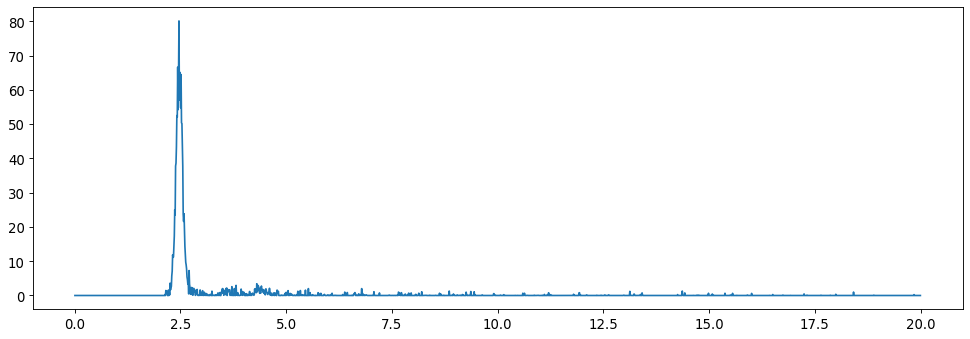

In [129]:
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
fig, ax = plt.subplots(1, 1, sharex=True, sharey=False, figsize=(15,5))
ax.plot(bin_centers, rdf_sum)
plt.show()

## Persistence Diagram

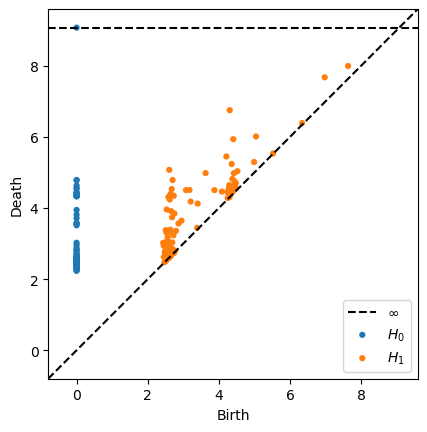

In [39]:
plot_diagrams(dgm_1, show=True)

PersImage(pixels=[1000, 1000], spread=2.0, specs={'minBD': 0, 'maxBD': 100}, kernel_type="gaussian", weighting_type="linear")


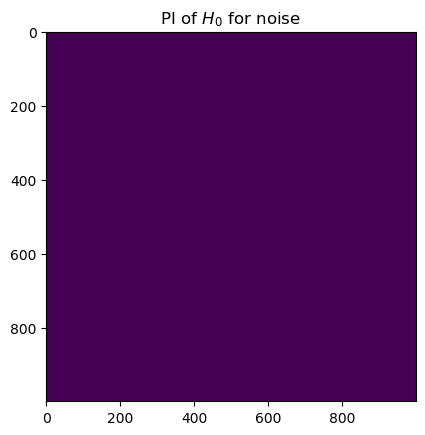

In [34]:
imgs = PersImage(pixels=[1000]*2, 
          spread=2.0, 
          specs={"minBD": 0, "maxBD": 100}).transform([dgm_1[0]][:-1])

ax = plt.subplot()
ax.imshow(imgs)
plt.title("PI of $H_0$ for noise")
plt.show()

In [ ]:
dgm_h0 = [dgm_1[0][:-1]]
# dgm_h1 = [dgm_1[1]]

pim = PersImage(pixels=[300,300], spread=2.0, specs={"minBD": 0, "maxBD": 30})
imgs = pim.transform(dgm_h0)

imgs_array = np.array([img.flatten() for img in imgs])
ax = plt.subplot()
ax.imshow(imgs[0])
plt.title("PI of $H_0$ for noise")
plt.show()

## Persistence Image

PersImage(pixels=[300, 300], spread=2.0, specs={'minBD': 0, 'maxBD': 30}, kernel_type="gaussian", weighting_type="linear")


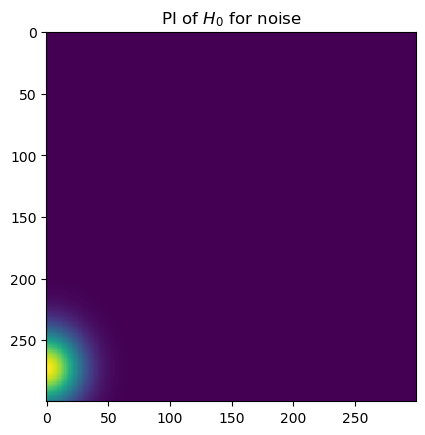

In [99]:
dgm_h0 = [dgm_1[0][:-1]]
# dgm_h1 = [dgm_1[1]]

pim = PersImage(pixels=[300,300], spread=2.0, specs={"minBD": 0, "maxBD": 30})
imgs = pim.transform(dgm_h0)

imgs_array = np.array([img.flatten() for img in imgs])
ax = plt.subplot()
ax.imshow(imgs[0])
plt.title("PI of $H_0$ for noise")
plt.show()

PersImage(pixels=[300, 300], spread=2.0, specs={'minBD': 0, 'maxBD': 30}, kernel_type="gaussian", weighting_type="linear")


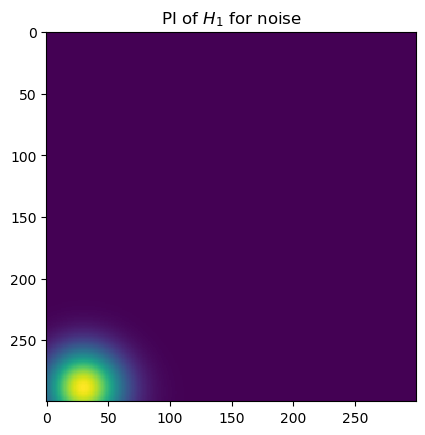

In [100]:
# dgm_h0 = [dgm_1[0][:-1]]
dgm_h1 = [dgm_1[1]]

pim = PersImage(pixels=[300,300], spread=2.0, specs={"minBD": 0, "maxBD": 30})
imgs = pim.transform(dgm_h1)

imgs_array = np.array([img.flatten() for img in imgs])
ax = plt.subplot()
ax.imshow(imgs[0])
plt.title("PI of $H_1$ for noise")
plt.show()

## Data generator loop

In [10]:
pka_list = [500, 1000, 2000, 5000, 10000, 20000, 50000]
nrun = 50
runs = np.arange(nrun)
hs = ["h0", "h1"]

dgm_dict = {}
for pka in pka_list:
    dgm_dict[pka] = {}
    for h in hs:
        dgm_dict[pka][h] = []

n_atoms = []
for pka in pka_list:
    for run in tqdm.tqdm_notebook(runs):       
        coords_sub = get_coords(pka=pka, run=run)
        n_atoms.append(len(coords_sub))
        if n_atoms[-1] is not 0:
#             rips = ripser(coords_sub)
#             dgms = rips['dgms']
#             dgm_dict[pka]["h0"].append(dgms[0])
#             dgm_dict[pka]["h1"].append(dgms[1])
            d = load_file("tda_05_nb/nb_01_tda_pka_{}_run_{}.pkl".format(pka, run))
            dgm_dict[pka]["h0"].append(d["h0"][0])
            dgm_dict[pka]["h1"].append(d["h1"][0])
            
save_file(fname="nb_05_tda_pka_50.pkl", obj=dgm_dict)

# Identify index of structures where cascade size is 0
indxs = np.where(np.asarray(n_atoms)!=0)[0]
print("No. of structures with no cascade: {}".format(len(indxs)))


No. of structures with no cascade: 350


### Load TDA descriptors for cascade structures

In [8]:
%%time
d = load_file(fname="pkls/nb_05_tda_pka_50.pkl")

CPU times: user 4.31 ms, sys: 4.7 ms, total: 9.01 ms
Wall time: 12.6 ms


In [9]:
%%time
pka_list = [500, 1000, 2000, 5000, 10000, 20000, 50000]
pka_values = [item/1000 for item in pka_list]
nrun = 50

label = np.concatenate([[0]*50] + [[i+1]*nrun for i in range(len(pka_list)-1)])

data_h0 = []
for pka in pka_list:
        data_h0 += d[pka]["h0"]
data_h0 = [item[:-1] for item in data_h0]

data_h1 = []
for pka in pka_list:
        data_h1 += d[pka]["h1"]

CPU times: user 215 µs, sys: 15 µs, total: 230 µs
Wall time: 223 µs


## Using H0 based new descriptor

In [10]:
len_pixel = 0.5
cutoff = 100
width = 5.0
nbins = int(np.floor(cutoff/len_pixel)+1)
bins = np.linspace(0.0, cutoff, nbins)
kernel = astat.epanechnikov_kernel(width=width, x=bins[1:])

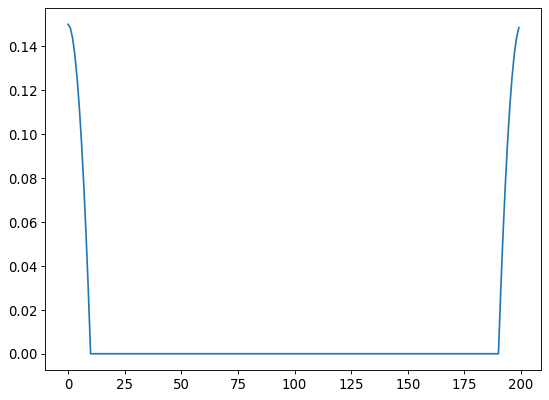

In [11]:
plt.plot(kernel)
plt.show()

In [13]:
rdf_list = []
pdf_list = []
for item in data_h0:
    rdf, bin_edges = np.histogram(item[:,1], bins)
    bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
    pdf = astat.convolve_kernel(kernel, rdf)

    rdf_list.append(rdf[None])
    pdf_list.append(pdf[None])

In [14]:
pad = int(width / len_pixel)
rdf_pad = np.pad(rdf, pad_width=[pad]*2)
kernel_pad = np.pad(kernel, pad_width=[pad]*2)

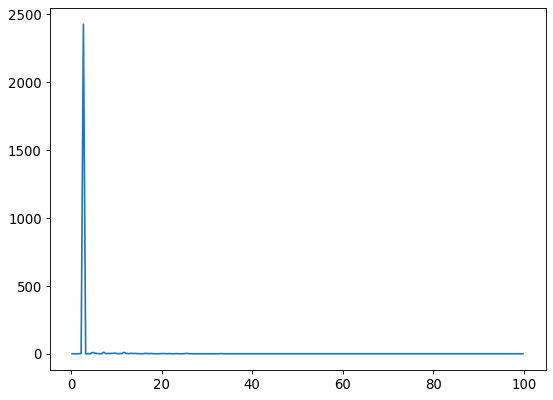

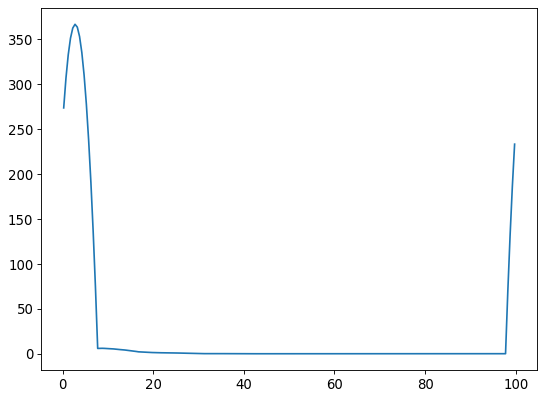

In [15]:
plt.plot(bin_centers, rdf_list[-1][0])
plt.show()

plt.plot(bin_centers, pdf_list[-1][0])
plt.show()

In [21]:
# x_data = normalize(np.concatenate(rdf_list, axis=0), axis=0)
x_data = np.concatenate(pdf_list, axis=0)
# x_data = np.concatenate(rdf_list, axis=0)

component: 0, ex_var_ratio: 0.99997
component: 1, ex_var_ratio: 0.00001
component: 2, ex_var_ratio: 0.00001
component: 3, ex_var_ratio: 0.00000
component: 4, ex_var_ratio: 0.00000
component: 5, ex_var_ratio: 0.00000
component: 6, ex_var_ratio: 0.00000
component: 7, ex_var_ratio: 0.00000
component: 8, ex_var_ratio: 0.00000
component: 9, ex_var_ratio: 0.00000


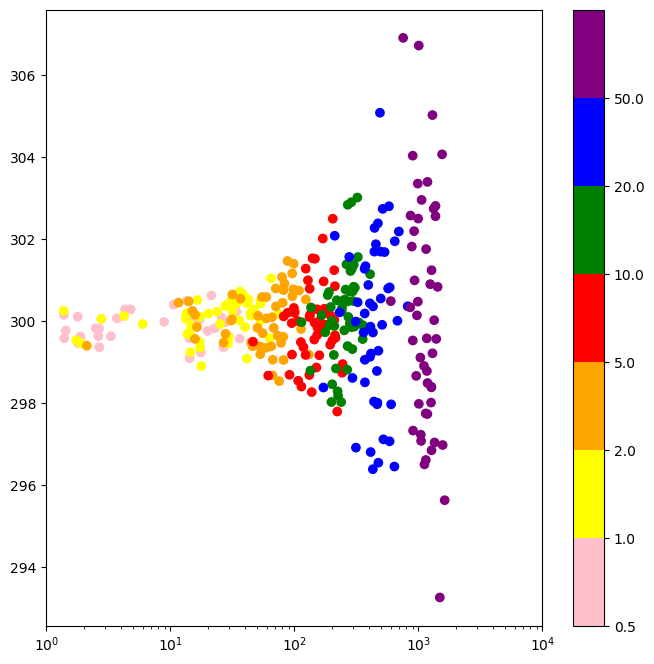

CPU times: user 13.7 s, sys: 833 ms, total: 14.5 s
Wall time: 1.19 s


In [22]:
%%time
X_emb = TSNE(n_components=2).fit_transform(x_data)
n_comp = 10
pca = PCA(n_components=n_comp)
X_emb = pca.fit_transform(x_data)+300


for ix, item in enumerate(pca.explained_variance_ratio_):
    print("component: {}, ex_var_ratio: {:1.5f}".format(ix, item))


colors = ['pink', 'yellow', 'orange', 'red', 'green', 'blue', "purple"]

fig = plt.figure(figsize=(8,8))
plt.scatter(X_emb[:,0], X_emb[:,1], c=label, cmap=matplotlib.colors.ListedColormap(colors))

cb = plt.colorbar()
loc = np.arange(0,max(label),max(label)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels([str(item/1000) for item in pka_list])
plt.xscale("log")
plt.xlim([1e0, 1e4])
plt.show()

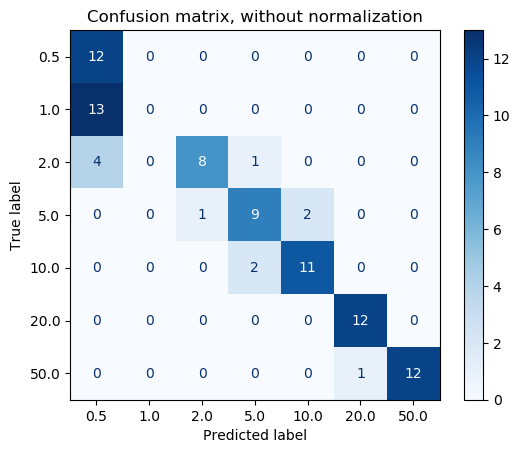

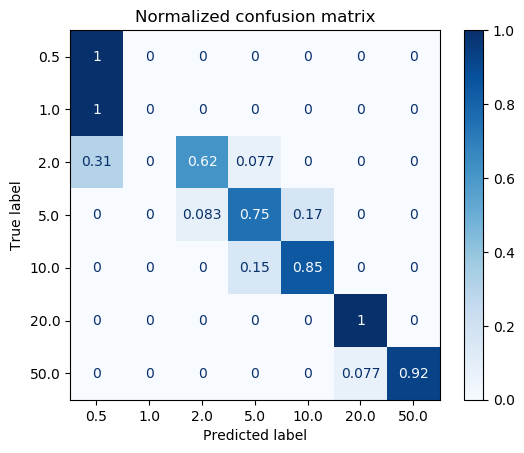

In [19]:
X_train, X_test, y_train, y_test = train_test_split(x_data, label, stratify=label)

clf = SVC(random_state=0, tol=1e-5, kernel="rbf")
clf.fit(X_train, y_train)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=[(item/1000) for item in pka_list],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
plt.show()

# Using persistent images

### Persistence image for h0

In [21]:
%%time
imgs_h0 = PersImage(pixels=[200,200], spread=5.0, specs={"minBD": 0, "maxBD": 100}).transform(data_h0)

PersImage(pixels=[200, 200], spread=5.0, specs={'minBD': 0, 'maxBD': 100}, kernel_type="gaussian", weighting_type="linear")
CPU times: user 1min 26s, sys: 417 ms, total: 1min 27s
Wall time: 1min 27s


### Persistence image for h1

In [22]:
%%time
imgs_h1 = PersImage(pixels=[300,300], spread=5.0, specs={"minBD": 0, "maxBD": 150}).transform(data_h1)

PersImage(pixels=[300, 300], spread=5.0, specs={'minBD': 0, 'maxBD': 150}, kernel_type="gaussian", weighting_type="linear")
CPU times: user 1min 46s, sys: 538 ms, total: 1min 47s
Wall time: 1min 47s


In [31]:
x_data_h0 = np.array([img[:,:50].flatten() for img in imgs_h0])
x_data_h1 = np.array([img.flatten() for img in imgs_h1])
# x_data_pdf = np.array([pdf.flatten() for pdf in pdf_list])

x_data = np.concatenate([x_data_h0, x_data_h1], axis=1)
# x_data_all = np.concatenate([x_data_h0, x_data_h1, x_data_pdf], axis=1)

label = np.concatenate([[0]*50] + [[i+1]*nrun for i in range(len(pka_list)-1)])

In [18]:
# save_file("nb_tda_smooth_5.pkl", x_data)

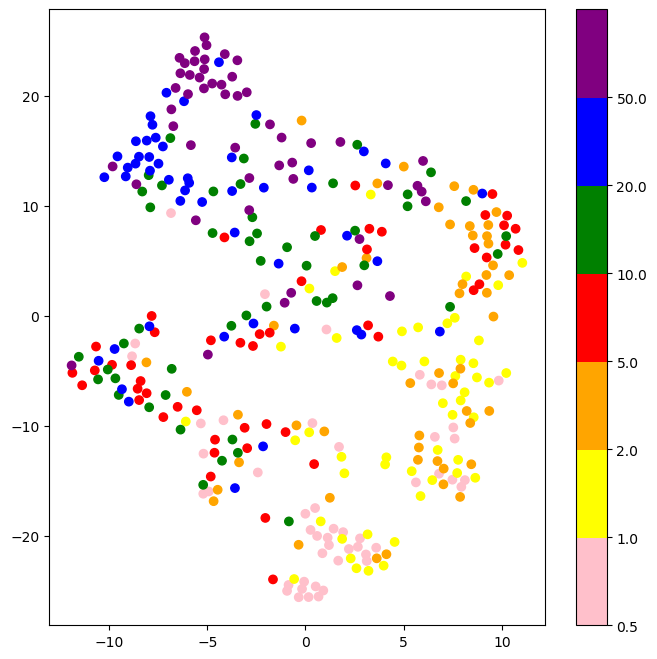

CPU times: user 19.8 s, sys: 381 ms, total: 20.2 s
Wall time: 2.05 s


In [33]:
%%time
x_pca = PCA(n_components=50).fit_transform(x_data)
X_emb = TSNE(n_components=2).fit_transform(x_pca)
# X_emb = PCA(n_components=2).fit_transform(x_data)+500
colors = ['pink', 'yellow', 'orange', 'red', 'green', 'blue', 'purple']

fig = plt.figure(figsize=(8,8))
plt.scatter(X_emb[:,0], X_emb[:,1], c=label, cmap=matplotlib.colors.ListedColormap(colors))

cb = plt.colorbar()
loc = np.arange(0,max(label),max(label)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels([str(item/1000) for item in pka_list])
# plt.xscale("log")
plt.show()

## A classification model to predict PKA label

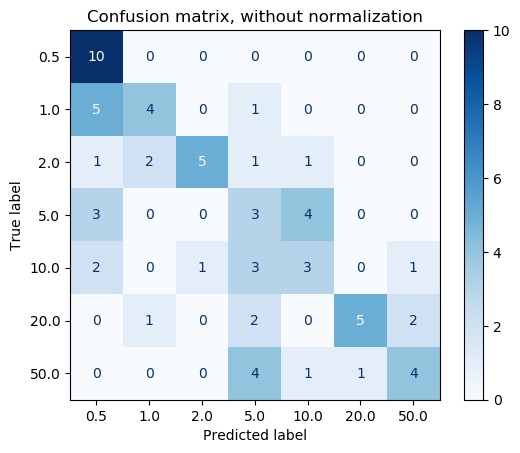

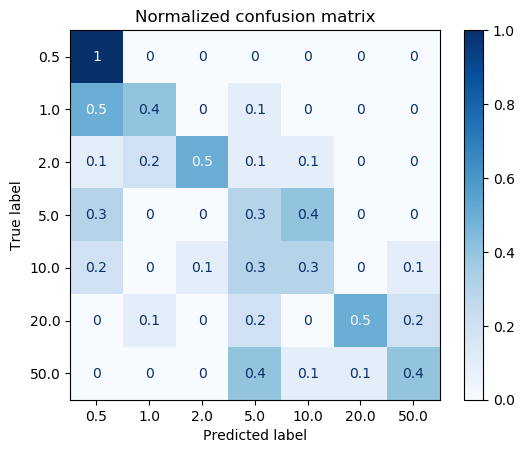

CPU times: user 20.1 s, sys: 259 ms, total: 20.4 s
Wall time: 20.6 s


In [34]:
%%time
X_train, X_test, y_train, y_test = train_test_split(x_data, 
                                                    label, 
                                                    stratify=label, 
                                                    test_size=0.20, 
                                                    random_state=0)
clf = SVC(random_state=0, tol=1e-5, C=0.1)
clf.fit(X_train, y_train)

# Plot non-normalized confusion matrix
np.set_printoptions(precision=2)
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, norm in titles_options:
    disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=[(item/1000) for item in pka_list],
                                 cmap=plt.cm.Blues,
                                 normalize=norm)
    disp.ax_.set_title(title)
plt.show()

In [157]:
%%time
dmap = scipy.spatial.distance.cdist(x_data, x_data, 'minkowski', p=2.)

CPU times: user 1min 13s, sys: 201 ms, total: 1min 13s
Wall time: 1min 13s
